# 05 – Play Style Clustering

Group team-seasons into style clusters using pace, efficiency, shooting, and ball movement.

## Goals
- Standardize key style features and fit K-Means to reveal distinct archetypes.
- Profile clusters by era and success rate.
- Visualize clusters on 2D projections (e.g., pace vs three-point rate).

In [18]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import pandas as pd

from src.pipeline.season_summary import generate_team_season_summary
from src.data_ingest import NBADataIngestor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [19]:
# Load team-season data.
summary_path = Path("data/processed/team_season_regular.csv")
if summary_path.exists():
    summary = pd.read_csv(summary_path)
else:
    ingestor = NBADataIngestor()
    summary = generate_team_season_summary(ingestor, regular_season_only=True, save=False)

summary.head()

,TEAM_ID,SEASON_YEAR,IS_PLAYOFFS,PACE,OFF_EFF_PER_100,DEF_EFF_PER_100,THREE_POINT_RATE,AST_TOV_RATIO,TOTAL_EST_POSSESSIONS,WIN_PCT,GAMES_PLAYED,ERA_KEY,ERA_LABEL,ERA_START_YEAR,ERA_END_YEAR
0,12304,2006,False,75.898936,137.024318,130.436611,0.303797,NaN,75.898936,1.0,1,pace_and_space_rise,Pace-and-Space Rise,2005,2013
1,12321,2012,False,88.874291,109.142925,102.391816,0.269231,1.0,88.874291,1.0,1,pace_and_space_rise,Pace-and-Space Rise,2005,2013
2,12321,2013,False,85.440470,95.973255,111.188527,0.411765,0.8125,85.440470,0.0,1,pace_and_space_rise,Pace-and-Space Rise,2005,2013
3,1610610024,1947,False,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,pre_shot_clock,Early BAA/NBL,1946,1953
4,1610610029,1948,False,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,pre_shot_clock,Early BAA/NBL,1946,1953


In [20]:
# Feature matrix for clustering.
feature_cols = [
    "PACE",
    "OFF_EFF_PER_100",
    "DEF_EFF_PER_100",
    "THREE_POINT_RATE",
    "AST_TOV_RATIO",
]

data = summary.dropna(subset=feature_cols).reset_index(drop=True)
X = data[feature_cols]

# Choose cluster count via silhouette scan.
scores = {}
for k in range(3, 8):
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=k, n_init=20, random_state=42))
    labels = model.fit_predict(X)
    scores[k] = silhouette_score(X, labels)

display(pd.DataFrame.from_dict(scores, orient="index", columns=["silhouette"]).rename_axis("k"))

,silhouette
k,
3,0.227563
4,0.250857
5,0.245695
6,0.190438
7,0.177148


In [21]:
# Fit final model (pick k based on silhouette peak).
optimal_k = max(scores, key=scores.get)
cluster_model = make_pipeline(StandardScaler(), KMeans(n_clusters=optimal_k, n_init=50, random_state=42))
labels = cluster_model.fit_predict(X)

data["CLUSTER"] = labels
centers = cluster_model.named_steps["kmeans"].cluster_centers_
centers_df = pd.DataFrame(centers, columns=feature_cols)
centers_df["CLUSTER"] = range(optimal_k)
centers_df

,PACE,OFF_EFF_PER_100,DEF_EFF_PER_100,THREE_POINT_RATE,AST_TOV_RATIO,CLUSTER
0,-0.523616,0.699280,-0.014967,-0.357901,0.510180,0
1,1.094711,0.007489,0.227993,-0.421306,-0.044357,1
2,-0.558404,-0.788479,-0.459228,0.030415,-0.671084,2
3,1.466786,1.644230,1.614591,1.842784,1.755046,3


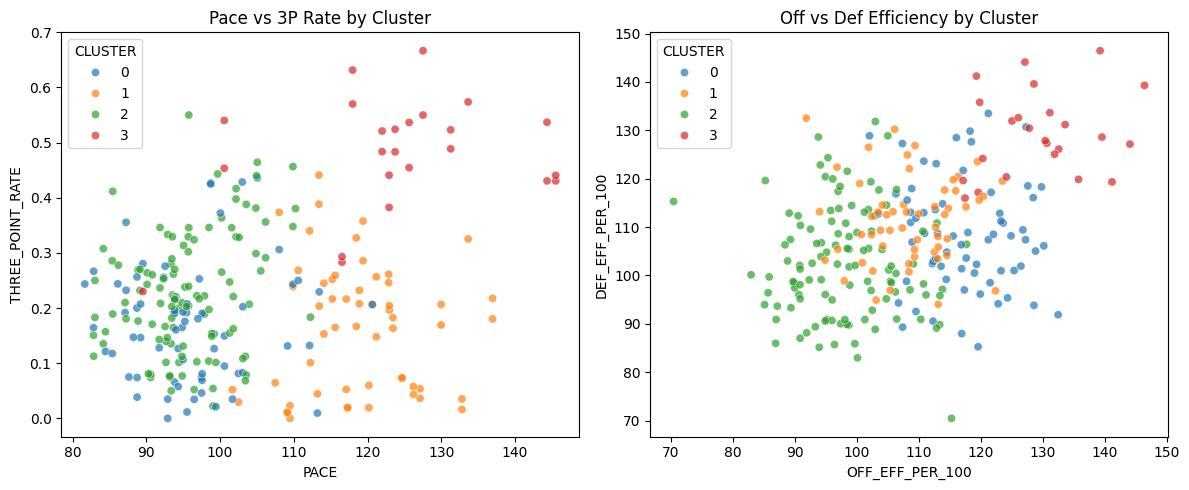

In [22]:
# Visualize clusters on key planes.
palette = sns.color_palette("tab10", n_colors=optimal_k)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(
    data=data,
    x="PACE",
    y="THREE_POINT_RATE",
    hue="CLUSTER",
    palette=palette,
    alpha=0.7,
    ax=axes[0],
)
axes[0].set_title("Pace vs 3P Rate by Cluster")

sns.scatterplot(
    data=data,
    x="OFF_EFF_PER_100",
    y="DEF_EFF_PER_100",
    hue="CLUSTER",
    palette=palette,
    alpha=0.7,
    ax=axes[1],
)
axes[1].set_title("Off vs Def Efficiency by Cluster")
plt.tight_layout()
plt.show()

In [23]:
# Cluster prevalence by era and win rate.
if {"ERA_LABEL", "WIN_PCT"}.issubset(data.columns):
    cluster_era = (
        data.groupby(["ERA_LABEL", "CLUSTER"])
        .agg(count=("TEAM_ID", "size"), avg_win=("WIN_PCT", "mean"))
        .reset_index()
    )
    display(cluster_era.sort_values(["ERA_LABEL", "CLUSTER"]))

# Save assignments for reuse if desired.
assignments_path = Path("data/processed/team_clusters.csv")
assignments_path.parent.mkdir(parents=True, exist_ok=True)
data[["TEAM_ID", "SEASON_YEAR", "CLUSTER"]].to_csv(assignments_path, index=False)
print(f"Cluster assignments saved to {assignments_path}")

,ERA_LABEL,CLUSTER,count,avg_win
0,Hand-Check / Iso Era,0,13,0.769231
1,Hand-Check / Iso Era,1,11,0.363636
2,Hand-Check / Iso Era,2,25,0.400000
3,Modern Pace & 3PT Revolution,0,7,0.714286
4,Modern Pace & 3PT Revolution,1,4,0.500000
5,Modern Pace & 3PT Revolution,2,30,0.433333
6,Modern Pace & 3PT Revolution,3,19,0.526316
7,Pace-and-Space Rise,0,14,0.785714
8,Pace-and-Space Rise,1,12,0.416667
9,Pace-and-Space Rise,2,34,0.411765


Cluster assignments saved to data/processed/team_clusters.csv


### Gaussian Mixture sanity check
Soft clustering alternative for reporting and to test cluster robustness.

In [24]:
# Fit GMM across candidate cluster counts using BIC/AIC.
gmm_scores = []
for k in range(3, 8):
    gmm = make_pipeline(StandardScaler(), GaussianMixture(n_components=k, random_state=42, n_init=5))
    gmm.fit(X)
    bic = gmm.named_steps["gaussianmixture"].bic(X)
    aic = gmm.named_steps["gaussianmixture"].aic(X)
    gmm_scores.append({"k": k, "bic": bic, "aic": aic})

gmm_df = pd.DataFrame(gmm_scores).set_index("k")
gmm_df


/Users/ameya/Documents/University/HW/CSE572/nba-stats/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(
/Users/ameya/Documents/University/HW/CSE572/nba-stats/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(
/Users/ameya/Documents/University/HW/CSE572/nba-stats/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(
/Users/ameya/Documents/University/HW/CSE572/nba-stats/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(
/Users/ameya/Documents/University/HW/CSE572/nba-stats/.venv/lib/python3.10/site-packages/skl

,bic,aic
k,,
3,1.940003e+07,1.939981e+07
4,2.154961e+07,2.154932e+07
5,2.446279e+07,2.446242e+07
6,2.170262e+07,2.170217e+07
7,2.297679e+07,2.297627e+07


/Users/ameya/Documents/University/HW/CSE572/nba-stats/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(


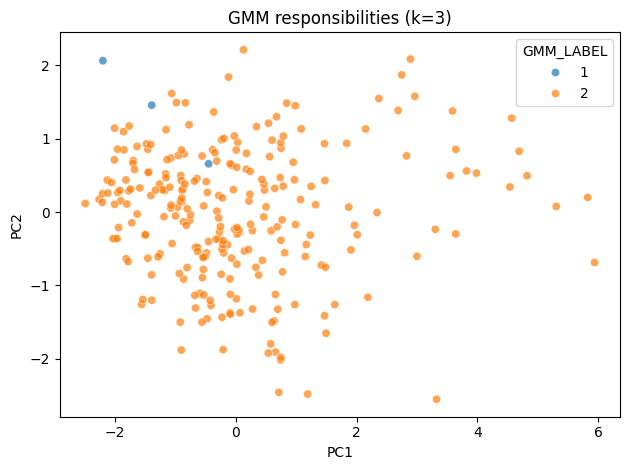

In [25]:
# Responsibilities for the best BIC model.
best_k = gmm_df["bic"].idxmin()
best_gmm = make_pipeline(StandardScaler(), GaussianMixture(n_components=int(best_k), random_state=42, n_init=10))
best_gmm.fit(X)
probs = best_gmm.named_steps["gaussianmixture"].predict_proba(X)

data_gmm = data.copy()
data_gmm[[f"GMM_{i}" for i in range(int(best_k))]] = probs

# 2D PCA projection colored by argmax responsibility.
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(StandardScaler().fit_transform(X))
data_gmm["PC1"], data_gmm["PC2"] = coords[:, 0], coords[:, 1]
data_gmm["GMM_LABEL"] = probs.argmax(axis=1)

sns.scatterplot(data=data_gmm, x="PC1", y="PC2", hue="GMM_LABEL", palette="tab10", alpha=0.7)
plt.title(f"GMM responsibilities (k={best_k})")
plt.tight_layout()
plt.show()

### K-Means stability across seeds
Check silhouette variation to report robustness.

In [26]:
stability = []
for seed in [1, 7, 21, 42, 84]:
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=optimal_k, n_init=20, random_state=seed))
    labels_seed = model.fit_predict(X)
    stability.append({"seed": seed, "silhouette": silhouette_score(X, labels_seed)})

stability_df = pd.DataFrame(stability).sort_values("silhouette", ascending=False)
stability_df


,seed,silhouette
1,7,0.250857
2,21,0.250857
3,42,0.250857
4,84,0.248788
0,1,0.237836


### Case study table (cluster exemplars)
Top win% team-seasons per cluster for narrative examples in the report.

In [27]:
case_rows = []
for cluster_id in sorted(data["CLUSTER"].unique()):
    cluster_slice = data[data["CLUSTER"] == cluster_id]
    top = cluster_slice.sort_values("WIN_PCT", ascending=False).head(2)
    for _, row in top.iterrows():
        case_rows.append(
            {
                "cluster": cluster_id,
                "team": row.get("TEAM_ID", "NA"),
                "season": int(row.get("SEASON_YEAR", 0)),
                "win_pct": row.get("WIN_PCT", np.nan),
                "pace": row.get("PACE", np.nan),
                "three_pt_rate": row.get("THREE_POINT_RATE", np.nan),
            }
        )

case_table = pd.DataFrame(case_rows).sort_values(["cluster", "win_pct"], ascending=[True, False])
case_table


,cluster,team,season,win_pct,pace,three_pt_rate
0,0,1610612737,2008,1.0,92.345269,0.255814
1,0,1610612747,1988,1.0,100.588750,0.149425
2,1,1610616834,2012,1.0,119.391964,0.285714
3,1,1610616834,2002,1.0,136.958933,0.180328
4,2,12321,2012,1.0,88.874291,0.269231
5,2,1610612746,1989,1.0,99.037208,0.022222
6,3,1610616833,2022,1.0,125.642251,0.536585
7,3,1610616834,2014,1.0,131.278221,0.488722


These outputs (GMM BIC/AIC, seed stability, exemplar teams) can be dropped into LaTeX tables to satisfy the rubric’s comparison and case-study expectations.

### Cluster transitions by franchise
Track how selected franchises move across clusters over time for narrative context.

In [28]:
# Count cluster switches per team and show a few exemplars.
team_switches = (
    data.sort_values(["TEAM_ID", "SEASON_YEAR"])
    .groupby("TEAM_ID")
    .agg(cluster_switches=("CLUSTER", lambda s: s.diff().ne(0).sum()))
    .reset_index()
    .sort_values("cluster_switches", ascending=False)
)
team_switches.head()

# Plot transitions for a handful of franchises if available.
watch_list = ["GSW", "HOU", "SAS", "BOS", "LAL", "DAL"]
plot_df = data[data["TEAM_ID"].isin(watch_list)].copy()
if not plot_df.empty:
    fig, ax = plt.subplots(figsize=(10, 5))
    for team, group in plot_df.groupby("TEAM_ID"):
        ax.plot(group["SEASON_YEAR"], group["CLUSTER"], marker="o", label=team)
    ax.set_ylabel("Cluster ID")
    ax.set_xlabel("Season year")
    ax.set_title("Cluster transitions for selected franchises")
    ax.legend(ncol=3)
    plt.tight_layout()
    plt.show()
else:
    print("No watch-list teams present in the dataset sample.")


No watch-list teams present in the dataset sample.


## Next Steps
- Try alternative clustering (Gaussian Mixture, HDBSCAN) to capture soft boundaries.
- Include defensive profile features (opponent 3P rate, turnover forcing) if available.
- Track cluster transitions for franchises over time to narrate stylistic evolution.